<a href="https://colab.research.google.com/github/transformernlp/explainablility/blob/main/shap_emotion_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install necessary libraries

In [ ]:
!pip -q install shap transformers datasets

     |████████████████████████████████| 358kB 8.6MB/s 
     |████████████████████████████████| 2.5MB 46.3MB/s 
     |████████████████████████████████| 245kB 41.6MB/s 
     |████████████████████████████████| 3.3MB 42.8MB/s 
     |████████████████████████████████| 901kB 51.2MB/s 
     |████████████████████████████████| 122kB 56.6MB/s 
     |████████████████████████████████| 245kB 52.0MB/s 


In [ ]:
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import shap
import scipy as sp
from datasets import load_dataset
import torch

In [ ]:
dataset  = load_dataset("emotion", split = "train")
data = pd.DataFrame({'text':dataset['text'],'emotion':dataset['label']})

Using custom data configuration default


Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/6e4212efe64fd33728549b8f0435c73081391d543b596a05936857df98acb681. Subsequent calls will reuse this data.


In [ ]:
data.head()

,text,emotion
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("nateraw/bert-base-uncased-emotion",use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained("nateraw/bert-base-uncased-emotion").cuda()

In [ ]:
id2label = model.config.id2label
label2id = model.config.label2id
labels = sorted(label2id, key=label2id.get)

In [ ]:
id2label

{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

In [ ]:
label2id

{'anger': 3, 'fear': 4, 'joy': 1, 'love': 2, 'sadness': 0, 'surprise': 5}

In [ ]:
labels

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

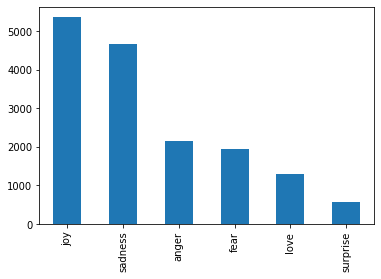

In [ ]:
ax = data.emotion.map(id2label).value_counts().plot.bar()

In [ ]:
def f(x):
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=128,truncation=True) for v in x]).cuda()
    attention_mask = (tv!=0).type(torch.int64).cuda()
    outputs = model(tv,attention_mask=attention_mask)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores) 
    return val

In [ ]:
explainer = shap.Explainer(f,tokenizer,output_names=labels)

In [ ]:
shap_values = explainer(data['text'][0:50])

Partition explainer: 51it [00:20,  2.51it/s]


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


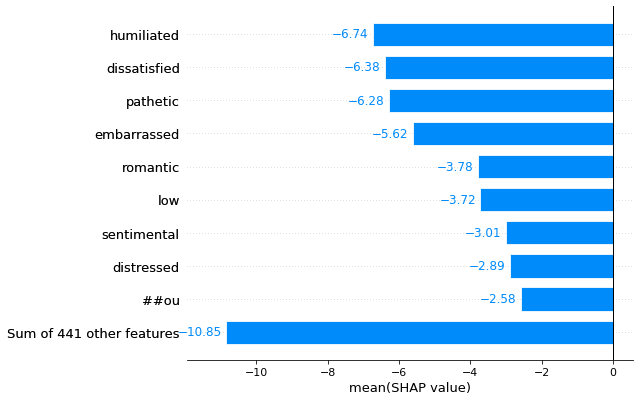

In [ ]:
shap.plots.bar(shap_values[:,:,"joy"].mean(0), order=shap.Explanation.argsort)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


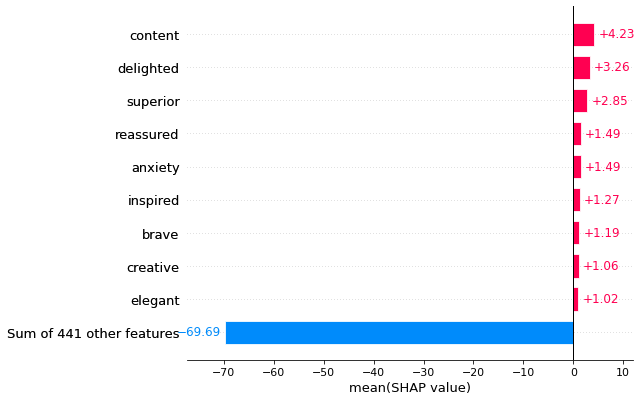

In [ ]:
shap.plots.bar(shap_values[:,:,"joy"].mean(0), order=shap.Explanation.argsort.flip)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


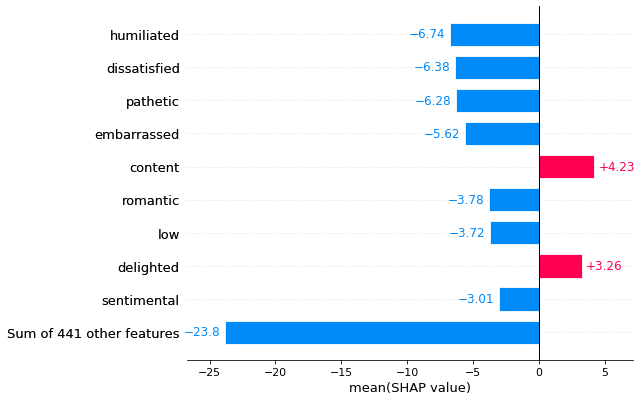

In [ ]:
shap.plots.bar(shap_values[:,:,"joy"].mean(0))

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


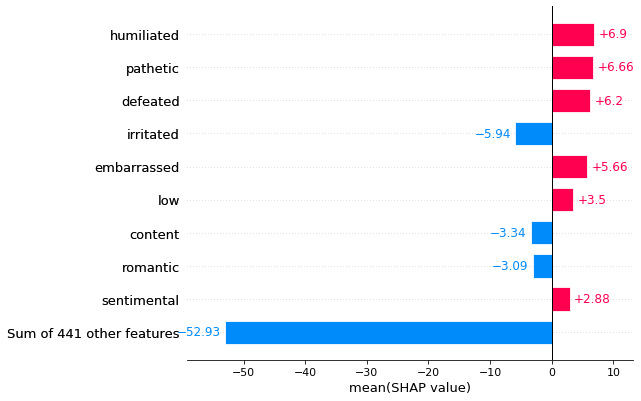

In [ ]:
shap.plots.bar(shap_values[:,:,"sadness"].mean(0))

In [ ]:
tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=128,truncation=True) for v in data['text'][:50]]).cuda()
attention_mask = (tv!=0).type(torch.int64).cuda()
outputs = model(tv,attention_mask=attention_mask)[0].detach().cpu().numpy()
print(outputs.shape)

(50, 6)


In [ ]:
outputs.argmax(axis=-1)[-7:]  ##PRED

array([2, 0, 0, 1, 2, 4, 3])

In [ ]:
data['emotion'][:50][-7:].values ##GOLD

array([1, 0, 0, 1, 2, 1, 3])

In [ ]:
data['text'][:50][-7:].values

array(['i feel very strongly passionate about when some jerk off decides to poke and make fun of us',
       'i was feeling so discouraged we are already robbing peter to pay paul to get our cow this year but we cant afford to not get the cow this way',
       'i was feeling listless from the need of new things something different',
       'i lost my special mind but don t worry i m still sane i just wanted you to feel what i felt while reading this book i don t know how many times it was said that sam was special but i can guarantee you it was many more times than what i used in that paragraph did i tell you she was special',
       'i can t let go of that sad feeling that i want to be accepted here in this first home of mine',
       'on a boat trip to denmark',
       'i stopped feeling cold and began feeling hot'], dtype=object)

In [ ]:
id2label

{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

In [ ]:
shap.plots.text(shap_values[-7:])

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


,,i feel,very strongly,passionate about when some,jerk off decides to poke,and make fun of us,
sadness,-0.0,-0.68,-0.739,-1.989,-0.093,-0.52,0.0
joy,-0.0,0.661,0.729,-0.208,-0.375,-0.499,-0.0
love,0.0,0.287,0.251,2.7,-0.027,-0.043,0.0
anger,-0.0,-1.506,-1.399,-2.511,0.311,0.699,-0.0
fear,-0.0,-0.76,-0.726,-2.09,0.055,-0.633,0.0
surprise,0.0,-0.751,-0.957,-2.302,-0.01,-0.448,-0.0


,,i was feeling so,discouraged we are already,robbing peter to pay paul to get our cow this year,but we cant afford to not get the cow this way,
sadness,0.0,1.568,3.743,0.672,1.158,0.0
joy,-0.0,-1.219,-4.03,-0.589,-0.072,-0.0
love,-0.0,-1.104,-2.758,-0.588,-0.675,-0.0
anger,-0.0,-1.838,-1.744,-0.354,-1.185,-0.0
fear,-0.0,-1.103,-2.067,-0.752,-1.305,0.0
surprise,-0.0,-1.332,-2.698,-1.066,-1.338,0.0


,,i was feeling,listless,from the,need of new things something different,
sadness,0.0,0.9,4.696,1.302,0.544,-0.0
joy,0.0,-0.511,-4.928,-1.044,-0.122,-0.0
love,0.0,-1.18,-3.038,-0.749,-0.47,-0.0
anger,-0.0,-2.314,-2.549,-0.64,-0.418,-0.0
fear,0.0,-1.67,-2.129,-0.233,-0.509,0.0
surprise,-0.0,-1.636,-3.107,-0.661,-0.597,-0.0


,,i lost my special mind but don t worry i,m still sane i just wanted you to feel what i felt while reading this book,i don t know how many times it was said that sam was special but,i can guarantee you it was many more times than what i used in that paragraph did i tell you she was special,
sadness,0.0,0.436,-1.883,-2.675,-1.275,-0.0
joy,-0.0,0.07,2.267,2.312,1.837,0.0
love,-0.0,-0.465,-0.236,-1.223,-1.12,0.0
anger,-0.0,0.086,-3.368,-1.792,-1.505,-0.0
fear,0.0,-0.29,-2.61,-1.637,-1.209,-0.0
surprise,0.0,-0.664,-2.006,-0.826,-1.349,-0.0


,,i can t let go of that sad,feeling that i want,to be accepted here,in this first home of mine,
sadness,0.0,1.671,-1.988,-4.323,0.496,-0.0
joy,0.0,-1.198,0.539,1.868,-0.588,-0.0
love,-0.0,-0.108,1.542,1.462,0.075,0.0
anger,0.0,-0.933,-1.35,-2.553,-0.564,-0.0
fear,0.0,-1.185,-1.074,-2.006,-0.494,-0.0
surprise,0.0,-1.233,-0.735,-1.495,-0.717,-0.0


,,on,a,boat trip,to,denmark,
sadness,-0.0,-0.179,-0.07,-0.082,-0.074,-0.294,0.0
joy,-0.0,-0.252,-0.139,-0.527,0.02,-0.197,0.0
love,-0.0,-0.508,-0.397,-0.914,-0.248,-0.538,0.0
anger,0.0,0.095,0.047,0.265,0.173,-0.032,0.0
fear,0.0,0.536,0.389,0.81,0.02,0.428,-0.0
surprise,0.0,-0.482,-0.347,-0.857,-0.285,-0.601,-0.0


,,i stopped,feeling cold,and,began feeling hot,
sadness,0.0,-0.164,-1.946,-0.159,-2.476,-0.0
joy,0.0,-0.511,-3.959,0.233,-1.838,-0.0
love,-0.0,-0.179,-5.743,-0.121,2.63,0.0
anger,0.0,0.261,7.263,0.054,-1.76,-0.0
fear,0.0,-0.009,-1.877,-0.008,-2.082,0.0
surprise,-0.0,0.116,-3.007,-0.009,-1.677,0.0
